https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [1]:
# Importing essential libraries and functions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

In [2]:
# Importing IMDb Movie Reviews dataset

df = pd.read_csv('IMDB-Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
# Checking for missing values

df.isna().sum()

review       0
sentiment    0
dtype: int64

In [8]:
df.duplicated().sum()

418

In [9]:
df.drop_duplicates(inplace=True, keep='last')

In [10]:
df.shape

(49582, 2)

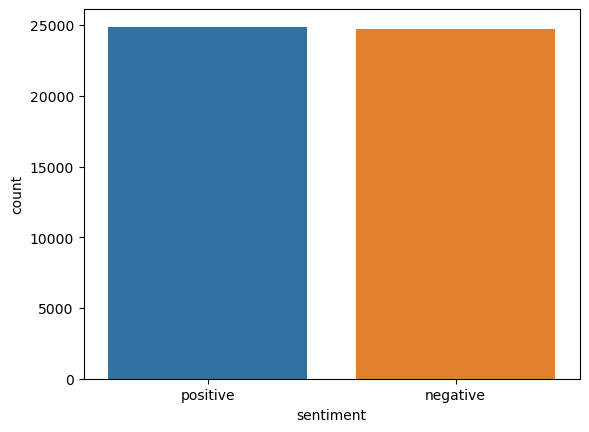

In [11]:
# Let's observe distribution of positive / negative sentiments in dataset
# ImBalanced Data
import seaborn as sns
sns.countplot(x='sentiment', data=df)
plt.show()

In [12]:
df['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

### Dataset Balancing

In [13]:
pos = df[df['sentiment']=='positive']
pos.shape

(24884, 2)

In [19]:
pos.head()

,review,sentiment
47242,"""Come Undone"" appears to elicit a lot of opini...",positive
43761,Caught the tail end of this movie channel surf...,positive
31426,"This is a ""docu-drama"" of (mostly) the later y...",positive
35193,Darr (1993) was an incredible movie. In my opi...,positive
3359,I grew up in Southern West Virginia; I'm about...,positive


In [14]:
neg = df[df['sentiment']=='negative']
neg.shape

(24698, 2)

In [20]:
neg.head()

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
10,Phil the Alien is one of those quirky films wh...,negative
11,I saw this movie when I was about 12 when it c...,negative


In [15]:
pos = pos.sample(neg.shape[0])

In [16]:
pos.shape

(24698, 2)

In [21]:
df = pd.concat([pos, neg], axis=0, ignore_index=True) # axis=0 (row)

In [22]:
df.head()

,review,sentiment
0,"""Come Undone"" appears to elicit a lot of opini...",positive
1,Caught the tail end of this movie channel surf...,positive
2,"This is a ""docu-drama"" of (mostly) the later y...",positive
3,Darr (1993) was an incredible movie. In my opi...,positive
4,I grew up in Southern West Virginia; I'm about...,positive


In [23]:
df.shape

(49396, 2)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49396 entries, 0 to 49395
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49396 non-null  object
 1   sentiment  49396 non-null  object
dtypes: object(2)
memory usage: 771.9+ KB


# Data Preprocessing

In [45]:
df['sentiment'] = df.sentiment.map({'negative':0 ,'positive':1})

In [ ]:
# 'he plays well!'
# 'he plays well'
# 'he' 'plays' 'well'
# 'plays' 'well'
# 'plays well'
# 'play good'
# 'play' 'good'
# [....] [....]

In [26]:
df['review'][0]

'"Come Undone" appears to elicit a lot of opinions among the contributors to this forum. Granted, it\'s a film that promises a take on gay life, as most viewers expect and somehow, it gets away from that promise into an introspective view at a young man\'s soul. The film has a way of staying with us even when it has ended. It is a character study about how a young man gets involved into a love affair with someone so much different than him that, in the end, will leave Mathieu confused, hurt and depressed when things don\'t go according to what he hoped the relationship would be.<br /><br />If you haven\'t seen the film, perhaps you would like to stop reading.<br /><br />Sebastien Lifshitz, the director of the film, has told his story from Mathieu\'s viewpoint. Most viewers appear to be disoriented by the different times within the film, but there are hints that are not obvious, as one can see, in retrospect. The story is told in flashbacks that might add to the way some people will vie

In [27]:
df['review'].apply(len)

0        3223
1         813
2         812
3         835
4         865
         ... 
49391     759
49392     642
49393    1280
49394    1234
49395     678
Name: review, Length: 49396, dtype: int64

In [28]:
df['review letter count'] = df['review'].apply(len)

In [29]:
df.head()

,review,sentiment,review letter count
0,"""Come Undone"" appears to elicit a lot of opini...",positive,3223
1,Caught the tail end of this movie channel surf...,positive,813
2,"This is a ""docu-drama"" of (mostly) the later y...",positive,812
3,Darr (1993) was an incredible movie. In my opi...,positive,835
4,I grew up in Southern West Virginia; I'm about...,positive,865


In [30]:
df['review letter count'].describe()

count    49396.000000
mean      1310.068508
std        990.511192
min         32.000000
25%        699.000000
50%        971.000000
75%       1590.000000
max      13704.000000
Name: review letter count, dtype: float64

In [31]:
df['review letter count'].idxmax() # index

4830

In [32]:
df.iloc[df['review letter count'].idxmax()]

review                 Match 1: Tag Team Table Match Bubba Ray and Sp...
sentiment                                                       positive
review letter count                                                13704
Name: 4830, dtype: object

In [33]:
df.iloc[df['review letter count'].idxmax()][0] # review

'Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, bu

In [34]:
df.iloc[df['review letter count'].idxmax()][1] # sentiment

'positive'

In [35]:
# Function to count words in a string
def count_words(text):
    # Splitting the text into words and counting
    words = text.split()
    return len(words)

# Apply the function to the 'review' column
df['word_counts'] = df['review'].apply(lambda x: count_words(x))

In [36]:
df.head()

,review,sentiment,review letter count,word_counts
0,"""Come Undone"" appears to elicit a lot of opini...",positive,3223,573
1,Caught the tail end of this movie channel surf...,positive,813,149
2,"This is a ""docu-drama"" of (mostly) the later y...",positive,812,139
3,Darr (1993) was an incredible movie. In my opi...,positive,835,133
4,I grew up in Southern West Virginia; I'm about...,positive,865,159


In [37]:
# Function to calculate average word length in a string
def avg_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

# Apply the function to the 'review' column
df['avg_wordlength'] = df['review'].apply(lambda x: avg_word_length(x))


In [38]:
df.head()

,review,sentiment,review letter count,word_counts,avg_wordlength
0,"""Come Undone"" appears to elicit a lot of opini...",positive,3223,573,4.626527
1,Caught the tail end of this movie channel surf...,positive,813,149,4.463087
2,"This is a ""docu-drama"" of (mostly) the later y...",positive,812,139,4.848921
3,Darr (1993) was an incredible movie. In my opi...,positive,835,133,5.285714
4,I grew up in Southern West Virginia; I'm about...,positive,865,159,4.446541


In [39]:
import nltk # Natural language Toolkit
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohdh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

stopwords_counts = []

for review in df['review']:
    # Split the review into words
    words = review.split()
    
    # Count the stopwords in the review
    count = sum(word in stop_words for word in words)
    
    stopwords_counts.append(count)

# Add the counts as a new column to the DataFrame
df['stopwords_counts'] = stopwords_counts

In [41]:
df.head()

,review,sentiment,review letter count,word_counts,avg_wordlength,stopwords_counts
0,"""Come Undone"" appears to elicit a lot of opini...",positive,3223,573,4.626527,259
1,Caught the tail end of this movie channel surf...,positive,813,149,4.463087,62
2,"This is a ""docu-drama"" of (mostly) the later y...",positive,812,139,4.848921,52
3,Darr (1993) was an incredible movie. In my opi...,positive,835,133,5.285714,39
4,I grew up in Southern West Virginia; I'm about...,positive,865,159,4.446541,62


### EDA (Exploratory Data Analysis)

In [42]:
import seaborn as sns

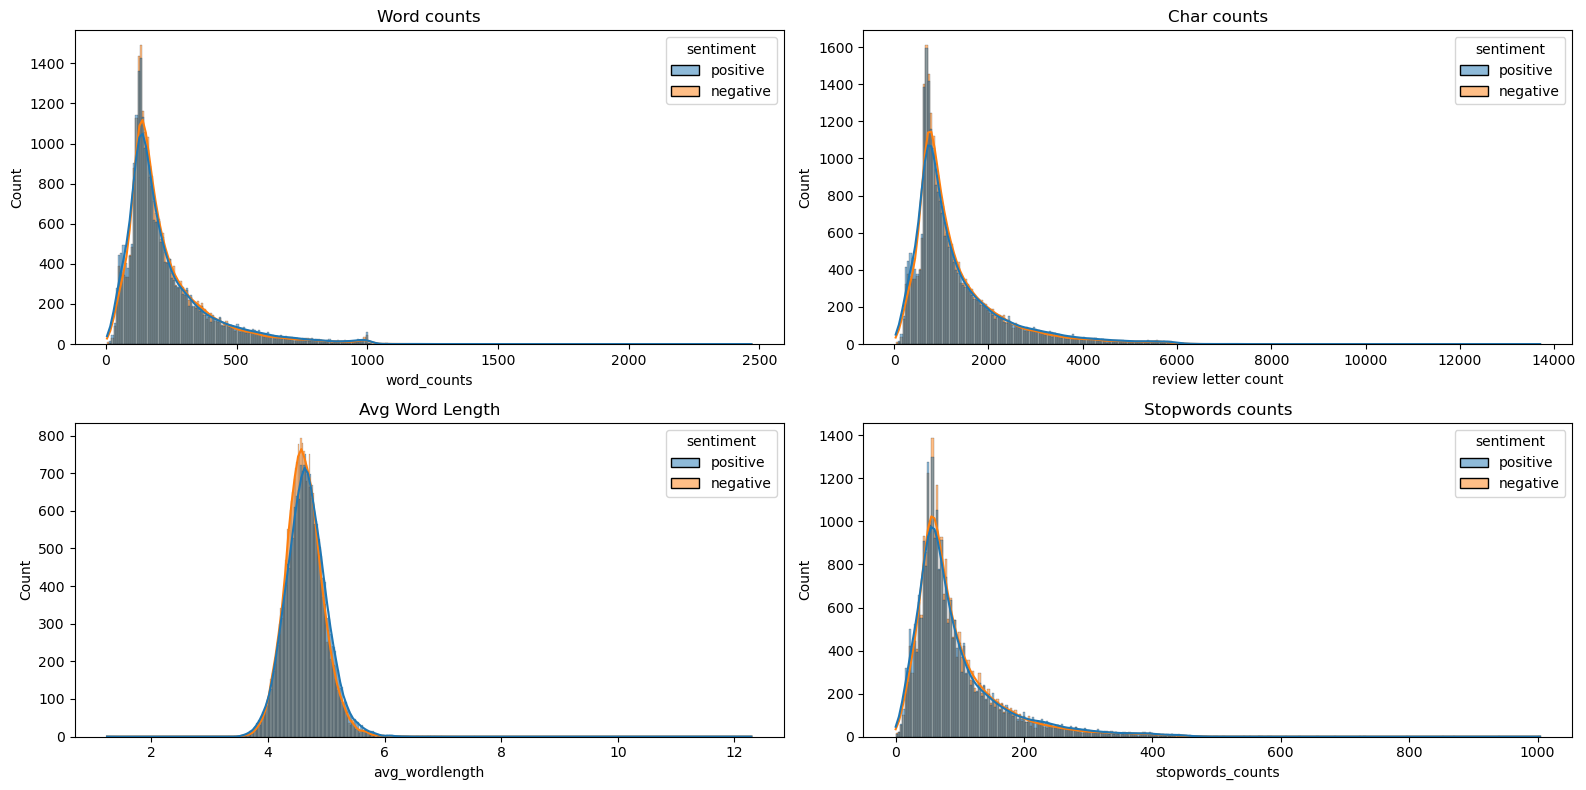

In [43]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
# sns.barplot(x='sentiment', y='word_counts', data=df)
sns.histplot(data=df, x='word_counts', hue='sentiment', kde=True)
plt.title('Word counts')

plt.subplot(2,2,2)
sns.histplot(data=df, x='review letter count', hue='sentiment', kde=True)
plt.title('Char counts')

plt.subplot(2,2,3)
sns.histplot(data=df, x='avg_wordlength', hue='sentiment', kde=True)
plt.title('Avg Word Length')

plt.subplot(2,2,4)
sns.histplot(data=df, x='stopwords_counts', hue='sentiment', kde=True)
plt.title('Stopwords counts')

plt.tight_layout()
plt.show()

In [44]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (10, 4)
plt.style.use('ggplot')

In [46]:
df['sentiment'].unique()

array([1, 0], dtype=int64)

In [47]:
pos = df[df['sentiment']== 1 ]
pos.shape

(24698, 6)

In [48]:
neg = df[df['sentiment']== 0 ]
neg.shape

(24698, 6)

In [50]:
df.columns

Index(['review', 'sentiment', 'review letter count', 'word_counts',
       'avg_wordlength', 'stopwords_counts'],
      dtype='object')

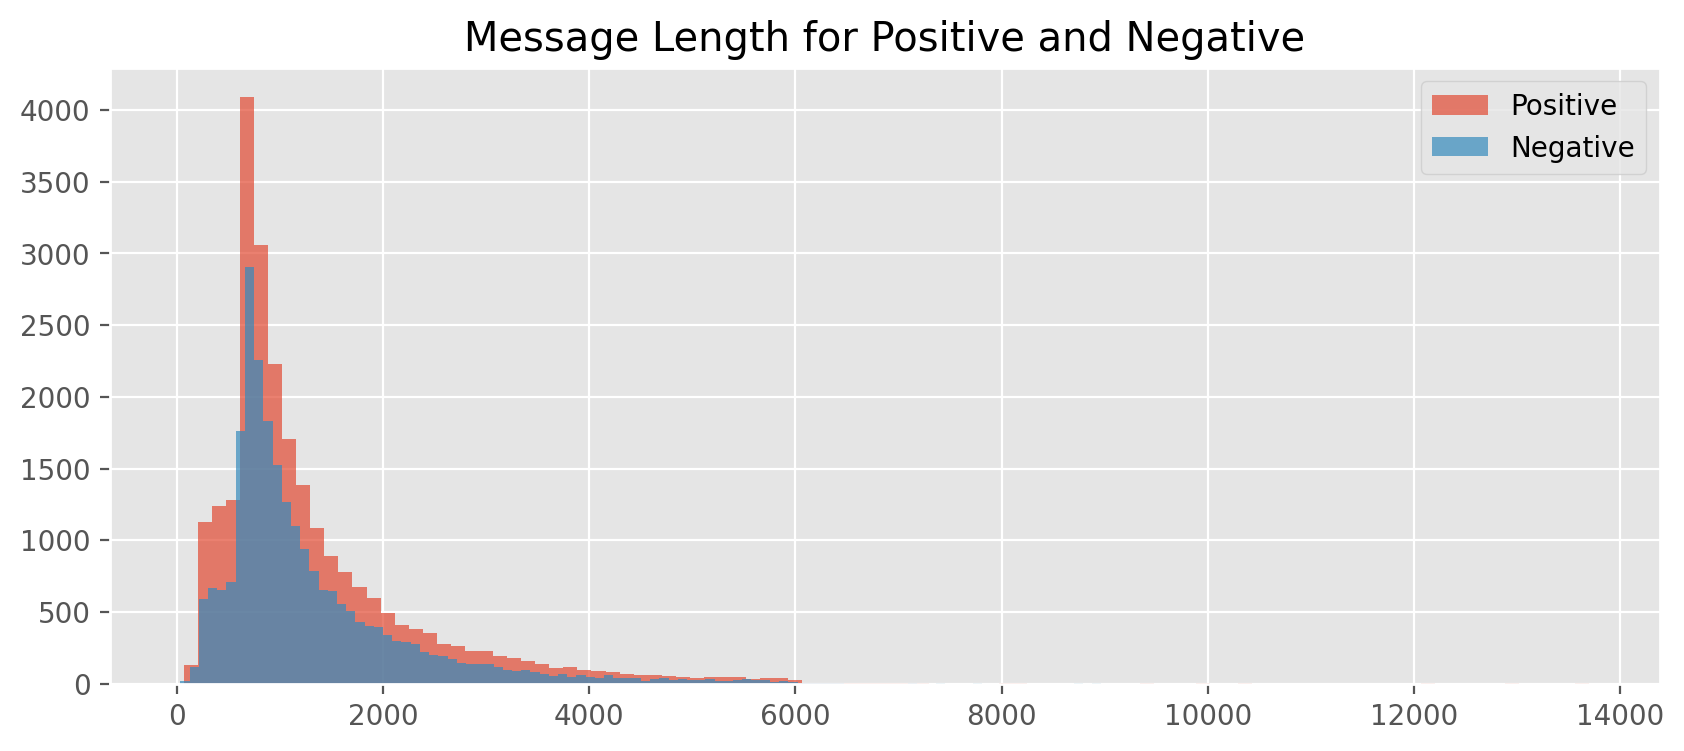

In [51]:
plt.hist(pos['review letter count'], bins=100, alpha=0.7, label='Positive')
plt.hist(neg['review letter count'], bins=100, alpha=0.7, label='Negative')
plt.title('Message letters Length for Positive and Negative')
plt.legend()
plt.show()

From this graph, we can observe that:

Most messages are relatively short, as indicated by the high frequency of messages with lower lengths.

The positive messages have a similar length distribution to the negative messages, although it's hard to determine precise differences without exact numbers or scale.

The graph is useful for visualizing how message length varies between positive and negative messages and could be used to assess whether there's a significant difference in the way people write messages based on their sentiment.

#### The histogram display a right-skewed (positively skewed) distribution for both positive and negative messages. In a right-skewed distribution:

#### The majority of the data points are concentrated on the left side of the histogram, with the tail stretching out to the right.

#### The mean and median will be greater than the mode, and the mean is typically the largest among the three measures of central tendency because it is pulled in the direction of the tail.

#### The bars representing both positive and negative message lengths taper off as they move towards the right side of the x-axis, which indicates that fewer messages have a very long length. This is characteristic of a positively skewed distribution. The bulk of the messages are shorter in length, as indicated by the taller bars on the left.

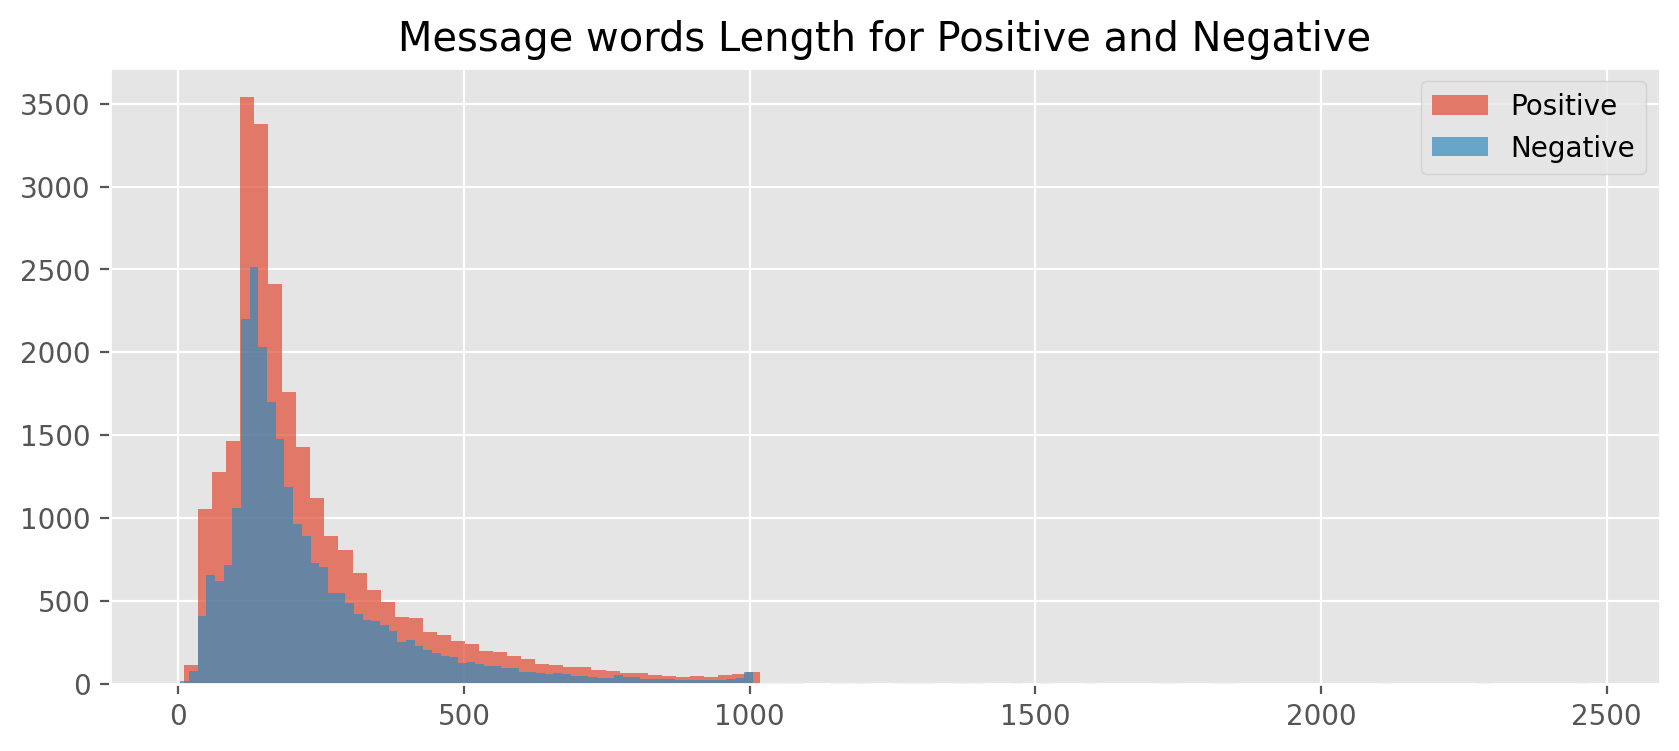

In [52]:
plt.hist(pos['word_counts'], bins=100, alpha=0.7, label='Positive')
plt.hist(neg['word_counts'], bins=100, alpha=0.7, label='Negative')
plt.title('Message words Length for Positive and Negative')
plt.legend()
plt.show()

# **********************************************

In [53]:
# Function to remove email addresses
def remove_emails(text):
    # Regular expression pattern for matching email addresses
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    # Replace email addresses with an empty string
    return re.sub(email_pattern, ' ', text)

# Apply the function to the DataFrame column

# df['reviews'] = df['reviews'].apply(lambda x: remove_emails(x))

In [54]:
# Function to remove HTML tags
def remove_html_tags(text):
    # Regular expression pattern for HTML tags
    html_pattern = re.compile('<.*?>')
    # Replace HTML tags with an empty string
    return html_pattern.sub(' ', text)

# Apply the function to the DataFrame column

# df['reviews'] = df['reviews'].apply(lambda x: remove_html_tags(x))

In [55]:
# Function to remove special characters
def remove_special_chars(text):
    # Regular expression pattern for non-alphanumeric characters (excluding basic punctuation)
    pattern = r'[^A-Za-z0-9 .,!?;:]'
    # Replace special characters with an empty string
    return re.sub(pattern, ' ', text)

# Apply the function to the DataFrame column

# df['reviews'] = df['reviews'].apply(lambda x: remove_special_chars(x))

In [56]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
corpus = []

for i in range(len(df)):
    sen = re.sub('[^a-zA-Z]', ' ', df['review'][i])
    sen = sen.split()
    sen = [word for word in sen if word not in stopwords.words('english')] 
    sen = [stemmer.stem(word) for word in sen]
    sen = ' '.join(sen)
    corpus.append(sen)

type(corpus)

list

In [57]:
temp = pd.DataFrame(corpus,columns=['review'])
temp.head()

,review
0,come undon appear elicit lot opinion among con...
1,caught tail end movi channel surf cabl movi ch...
2,thi docu drama mostli later year kw life nearl...
3,darr incred movi in opinion one bollywood fine...
4,i grew southern west virginia i age mayb year ...


In [58]:
df['review'][0]

'"Come Undone" appears to elicit a lot of opinions among the contributors to this forum. Granted, it\'s a film that promises a take on gay life, as most viewers expect and somehow, it gets away from that promise into an introspective view at a young man\'s soul. The film has a way of staying with us even when it has ended. It is a character study about how a young man gets involved into a love affair with someone so much different than him that, in the end, will leave Mathieu confused, hurt and depressed when things don\'t go according to what he hoped the relationship would be.<br /><br />If you haven\'t seen the film, perhaps you would like to stop reading.<br /><br />Sebastien Lifshitz, the director of the film, has told his story from Mathieu\'s viewpoint. Most viewers appear to be disoriented by the different times within the film, but there are hints that are not obvious, as one can see, in retrospect. The story is told in flashbacks that might add to the way some people will vie

In [59]:
temp['review'][0]

'come undon appear elicit lot opinion among contributor forum grant film promis take gay life viewer expect somehow get away promis introspect view young man soul the film way stay us even end it charact studi young man get involv love affair someon much differ end leav mathieu confus hurt depress thing go accord hope relationship would br br if seen film perhap would like stop read br br sebastien lifshitz director film told stori mathieu viewpoint most viewer appear disori differ time within film hint obviou one see retrospect the stori told flashback might add way peopl view film thi stori doom love mathieu felt cedric ultim breakdown life togeth br br first cedric handsom young local pursu mathieu succe convinc like mathieu feel attract cedric we realiz differ young men way cedric tell mathieu famili feel school on hand mathieu want architect find beauti abandon place cedric taken we watch mathieu read guid book want cedric attent br br when mathieu come mother wise tell import con

In [60]:
df['review'] = temp['review']
df['review'][0]

'come undon appear elicit lot opinion among contributor forum grant film promis take gay life viewer expect somehow get away promis introspect view young man soul the film way stay us even end it charact studi young man get involv love affair someon much differ end leav mathieu confus hurt depress thing go accord hope relationship would br br if seen film perhap would like stop read br br sebastien lifshitz director film told stori mathieu viewpoint most viewer appear disori differ time within film hint obviou one see retrospect the stori told flashback might add way peopl view film thi stori doom love mathieu felt cedric ultim breakdown life togeth br br first cedric handsom young local pursu mathieu succe convinc like mathieu feel attract cedric we realiz differ young men way cedric tell mathieu famili feel school on hand mathieu want architect find beauti abandon place cedric taken we watch mathieu read guid book want cedric attent br br when mathieu come mother wise tell import con

In [64]:
df.shape

(49396, 6)

In [61]:
df.to_csv('IMDB_clean.csv', index=False)

In [62]:
data = pd.read_csv('IMDB_clean.csv')
data.head()

,review,sentiment,review letter count,word_counts,avg_wordlength,stopwords_counts
0,come undon appear elicit lot opinion among con...,1,3223,573,4.626527,259
1,caught tail end movi channel surf cabl movi ch...,1,813,149,4.463087,62
2,thi docu drama mostli later year kw life nearl...,1,812,139,4.848921,52
3,darr incred movi in opinion one bollywood fine...,1,835,133,5.285714,39
4,i grew southern west virginia i age mayb year ...,1,865,159,4.446541,62


In [63]:
data['review'][0]

'come undon appear elicit lot opinion among contributor forum grant film promis take gay life viewer expect somehow get away promis introspect view young man soul the film way stay us even end it charact studi young man get involv love affair someon much differ end leav mathieu confus hurt depress thing go accord hope relationship would br br if seen film perhap would like stop read br br sebastien lifshitz director film told stori mathieu viewpoint most viewer appear disori differ time within film hint obviou one see retrospect the stori told flashback might add way peopl view film thi stori doom love mathieu felt cedric ultim breakdown life togeth br br first cedric handsom young local pursu mathieu succe convinc like mathieu feel attract cedric we realiz differ young men way cedric tell mathieu famili feel school on hand mathieu want architect find beauti abandon place cedric taken we watch mathieu read guid book want cedric attent br br when mathieu come mother wise tell import con

In [65]:
data.shape

(49396, 6)